In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [2]:
data = pd.read_csv('../data_sets/ou_SIRH_data_nbinom.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRH_state_nbinom.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRH_betas_nbinom.csv').to_numpy()

In [3]:
pmcmc_output = np.load('../pmcmc_output/SIRH_pmcmc_output.npz')

In [4]:
def SIRH_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,R,mu,sig = model_params

    lam = 1/50
    
    D = 1/7
    L = 0 
    hosp = 1/14

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_S = rng.poisson((L * particles[index,3,t]) * dt)
        new_I = rng.poisson((particles[index,4,t] * (particles[index,0,t] * particles[index,1,t])/np.sum(particles[index,:,t])) * dt)
        new_IH = rng.poisson((D * gamma * particles[index,1,t]) * dt)
        new_HR = rng.poisson((hosp * particles[index,2,t]) * dt)
        new_IR = rng.poisson((D *(1 - gamma) * particles[index,2,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] + new_S - new_I)
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - (new_IH + new_IR))
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_IH - new_HR)
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_HR + new_IR - new_S)

        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SIRH_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[1]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0] + 0.005),n = np.array([r]))
    return weights


In [5]:
def SIRH_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    I_init = rng.integers(1,5,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,4] = rng.uniform(0.,0.2, size = (num_particles,))
    

    return particles_0

In [6]:
burn_in = 10_000
dt = 0.1
rng = np.random.default_rng()



par = np.mean((pmcmc_output['accepted_params'][:,burn_in:]),axis = 1)

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )



 Log Likelihood : -1316.4652095628535
Root Mean Squared Error for the Data 1143.4089473382442


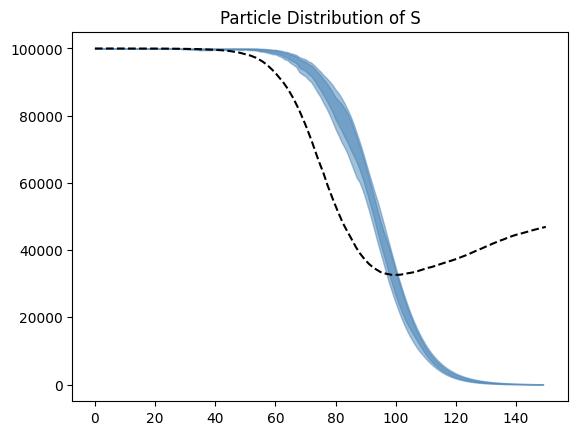

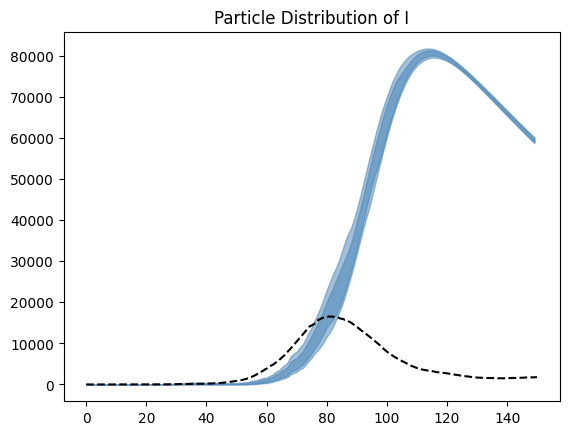

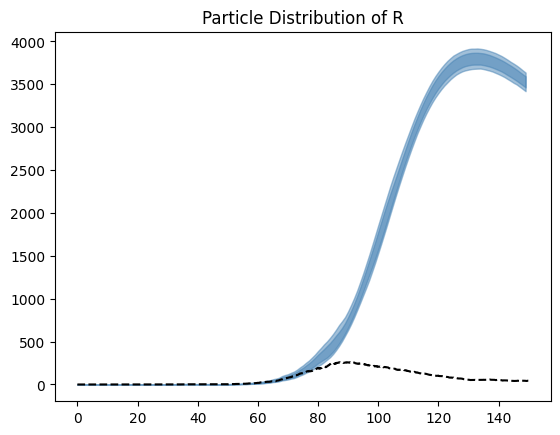

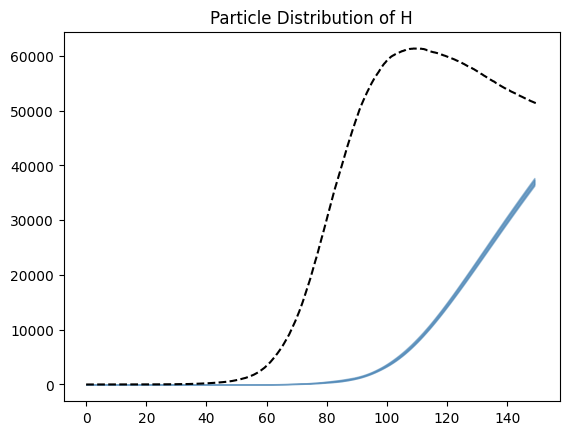

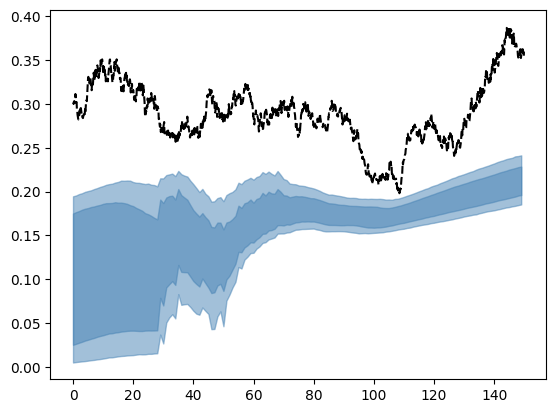

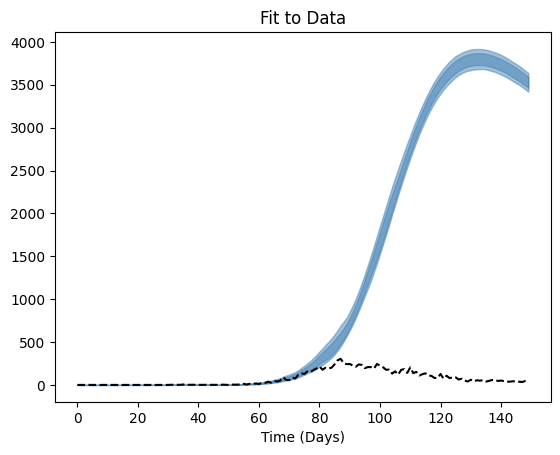

In [8]:
T = 150
dt = 0.1
t_vec = np.arange(0,T,dt)

'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

dt = pf_params['dt']
Labels = ['S','I','R','H']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()